
# Analiza danych federacji IHRF

**Autor:** Wojciech Derda

**Data:** 01.02.2026

**Źródło danych:** baza danych `ihrf`  
**Narzędzia:** Python (pandas, matplotlib), Jupyter Notebook



## 1. Wprowadzenie

Celem raportu jest analiza działalności federacji IHRF, obejmująca:
1) wyniki sportowe chomików i długość ich kariery ,
2) wpływ majątku właściciela na wyniki chomika,
3) popularność sportu w czasie i wyniki finansowe federacji,
4) wpływ wieku chomika na wyniki
5) wpływ płci chomika na wyniki
6) wpływ doświadczenia chomika na wyniki
7) sprawdzenie czy różne dyscypliny są tak samo konkurencyjne


## 2. Opis danych i założenia

W analizie wykorzystano tabele: `competitions`, `disciplines`, `hamsters`, `employees`,
`funding_sources`, `sponsorships`, `doping_controls`.

**Uwaga metodologiczna:** baza przechowuje tylko zwycięzcę dla danych zawodów, ale przyjmujemy, że każdy chomik startuje we wszystkich zawodach w których może wziąć udział


## 3. Połączenie z bazą i wczytanie danych

W tej części nawiązujemy połączenie z bazą `ihrf` i wczytujemy tabele do środowiska `pandas`.
Daty są konwertowane do typu `datetime`, aby umożliwić analizę czasową.


In [2]:
import warnings
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

DB_NAME = "ihrf"
CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "root_password",
    "database": DB_NAME,
}

conn = mysql.connector.connect(**CONFIG)
warnings.filterwarnings(
    "ignore",
    message="pandas only supports SQLAlchemy connectable"
)
print("Połączono z bazą")


Połączono z bazą


In [3]:
def read_sql(q):
    return pd.read_sql(q, conn)

employees = read_sql("SELECT * FROM employees")
hamsters = read_sql("SELECT * FROM hamsters")
disciplines = read_sql("SELECT * FROM disciplines")
competitions = read_sql("SELECT * FROM competitions")
doping_controls = read_sql("SELECT * FROM doping_controls")

for df in [employees, hamsters, competitions, doping_controls]:
    for c in df.columns:
        if "date" in c:
            df[c] = pd.to_datetime(df[c])


## 4. Przygotowanie tabeli do analizy

Na potrzeby analizy tworzona jest jedna zbiorcza tabela `comp` poprzez połączenie:
- `competitions` (zawody),
- `disciplines` (opis konkurencji),
- `hamsters` (dane zawodników i właścicieli).

Każdy wiersz w `comp` odpowiada jednemu zwycięstwu w zawodach wraz z kontekstem dyscypliny oraz cechami chomika.
Dodatkowo wyodrębniamy kolumnę `year` do analizy trendów.


In [4]:

comp = competitions.merge(disciplines, on="discipline_id").merge(hamsters, on="hamster_id", suffixes=("", "_hamster"))

comp["year"] = comp["competition_date"].dt.year
comp.head()


,competition_id,discipline_id,competition_date,location,spectators_stadium,hamster_id,winner_result,name,category,description,name_hamster,birth_date,retire_date,sex,owner_id,owner_name,owner_networth,year
0,1,1,2019-03-30,Buenos Aires,7293,61,1.39,Bieg na 2m,naturalna,Sprint na dystansie 2m,Chrupek3,2019-01-11,2022-01-14,M,39,Kamil Nowak,4704425.67,2019
1,2,4,2019-09-25,Vancouver,6293,21,5.13,Formuła CH: Sprint,formula_ch,Wyścig na 20m,Błysk6,2019-06-13,2022-06-16,F,14,Robert Wojciechowski,6823846.22,2019
2,3,3,2019-06-23,Sydney,5348,26,20.36,Bieg przez płotki,naturalna,Bieg przez płotki na dystansie 20m,Mocha,2019-04-24,2021-01-16,F,12,Tadeusz Olszewski,5810091.44,2019
3,4,3,2019-10-13,Paryż,4700,61,9.25,Bieg przez płotki,naturalna,Bieg przez płotki na dystansie 20m,Chrupek3,2019-01-11,2022-01-14,M,39,Kamil Nowak,4704425.67,2019
4,5,5,2019-06-20,Kair,3231,61,499.57,Formuła CH: Endurance,formula_ch,Wyścig na 1km,Chrupek3,2019-01-11,2022-01-14,M,39,Kamil Nowak,4704425.67,2019


## 5. Najlepsi sportowcy w dyscyplinach

Wyznaczamy najlepszego chomika osobno dla każdej dyscypliny (`discipline_id`).
Ponieważ `winner_result` to czas (mniej = lepiej), porównania wewnątrz dyscyplin opieramy o
znormalizowany wynik oraz liczbę zwycięstw.


In [5]:
#Normalizacja wyników w obrębie dyscypliny
comp["z"] = comp.groupby("discipline_id")["winner_result"].transform(
    lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) > 0 else 1.0)
)

#Score: im większy, tym lepiej -> odwracamy znak, bo mniejszy czas jest lepszy
comp["score"] = -comp["z"]

#Ranking chomików w każdej dyscyplinie
rank_disc = (
    comp
    .groupby(
        ["discipline_id", "name", "category", "hamster_id", "name_hamster"],
        as_index=False
    )
    .agg(
        wins=("competition_id", "count"),
        avg_score=("score", "mean"),
        best_time=("winner_result", "min"),
        avg_time=("winner_result", "mean"),
        first_win=("competition_date", "min"),
        last_win=("competition_date", "max")
    )
)

# liczba zwycięstw + 0.5*jakość wyników - zwycięestwa są ważniejsze niż dobre czasy
rank_disc["combined"] = rank_disc["wins"] + 0.5 * rank_disc["avg_score"]

# Najlepszy chomik dla każdej dyscypliny
best_by_discipline = (
    rank_disc
    .sort_values(["discipline_id", "combined"], ascending=[True, False])
    .groupby("discipline_id")
    .head(1)
    .sort_values("discipline_id")
)

# Wynik końcowy
best_by_discipline[
    [
        "discipline_id",
        "name",
        "category",
        "hamster_id",
        "name_hamster",
        "wins",
        "best_time",
        "avg_time",
        "avg_score",
        "first_win",
        "last_win",
    ]
]


,discipline_id,name,category,hamster_id,name_hamster,wins,best_time,avg_time,avg_score,first_win,last_win
10,1,Bieg na 2m,naturalna,61,Chrupek3,3,1.39,2.010,0.624710,2019-03-30,2019-07-12
25,2,Bieg na 100m,naturalna,67,Błysk,2,24.21,27.790,-0.296386,2022-08-26,2022-12-14
33,3,Bieg przez płotki,naturalna,25,Biszkopt,2,5.02,6.655,1.297460,2020-03-16,2021-11-11
61,4,Formuła CH: Sprint,formula_ch,61,Chrupek3,1,2.03,2.030,2.063318,2019-03-12,2019-03-12
69,5,Formuła CH: Endurance,formula_ch,26,Mocha,2,196.82,321.465,0.254129,2019-07-12,2019-12-10


## 6. Jak długo trwa „szczyt kariery” u chomików?

„Szczyt kariery” definiujemy jako okres pomiędzy pierwszym a ostatnim zwycięstwem chomika
(w analizie uwzględniamy chomiki z co najmniej dwoma zwycięstwami).
Pokazujemy statystyki opisowe oraz rozkład długości szczytu kariery.


Liczba chomików z >=2 zwycięstwami: 19
Średni szczyt kariery: 454.9 dni
Mediana szczytu kariery: 534.0 dni
25%–75%: 228.0 – 591.5 dni


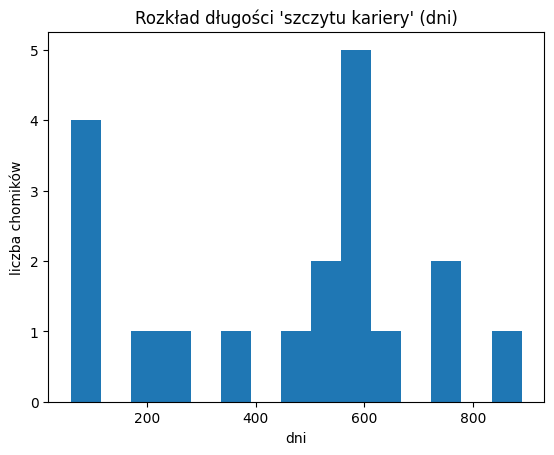

In [6]:
career = (
    comp.groupby(["hamster_id", "name_hamster"], as_index=False)
        .agg(
            wins=("competition_id", "count"),
            first_win=("competition_date", "min"),
            last_win=("competition_date", "max")
        )
)

career2 = career[career["wins"] >= 2].copy()
career2["peak_days"] = (career2["last_win"] - career2["first_win"]).dt.days
print("Liczba chomików z >=2 zwycięstwami:", len(career2))
print("Średni szczyt kariery:", round(career2["peak_days"].mean(), 1), "dni")
print("Mediana szczytu kariery:", round(career2["peak_days"].median(), 1), "dni")
print("25%–75%:", career2["peak_days"].quantile(0.25), "–", career2["peak_days"].quantile(0.75), "dni")

plt.figure()
plt.hist(career2["peak_days"], bins=15)
plt.title("Rozkład długości 'szczytu kariery' (dni)")
plt.xlabel("dni")
plt.ylabel("liczba chomików")
plt.show()

## 7. Wpływ majątku właściciela na wyniki

Sprawdzamy, czy majątek właściciela (`owner_networth`) wiąże się z lepszymi wynikami sportowymi.
Stosujemy tu porównanie grup (najbogatsi 25% vs najbiedniejsi 25%) testem Manna–Whitneya.


In [7]:
rows = []

for cat, sub in comp.groupby("category"):
    q1 = sub["owner_networth"].quantile(0.25)
    q3 = sub["owner_networth"].quantile(0.75)

    bottom = sub[sub["owner_networth"] <= q1]["score"]
    top = sub[sub["owner_networth"] >= q3]["score"]

    # jeśli za mało danych, nie robimy testu
    if len(top) < 8 or len(bottom) < 8:
        p = np.nan
        conclusion = "za mało danych"
    else:
        _, p = stats.mannwhitneyu(top, bottom, alternative="two-sided")
        if p < 0.05 and top.mean() > bottom.mean():
            conclusion = "TAK (bogaci)"
        elif p < 0.05 and top.mean() < bottom.mean():
            conclusion = "TAK (biedni)"
        else:
            conclusion = "NIE"

    rows.append({
        "category": cat,
        "top25_mean_score": round(top.mean(), 3) if len(top) else np.nan,
        "bottom25_mean_score": round(bottom.mean(), 3) if len(bottom) else np.nan,
        "p_value": round(p, 4) if pd.notna(p) else np.nan,
        "wniosek": conclusion
    })

adv_by_category = pd.DataFrame(rows).sort_values("p_value", na_position="last")
adv_by_category


,category,top25_mean_score,bottom25_mean_score,p_value,wniosek
1,naturalna,-0.239,0.007,0.4553,NIE
0,formula_ch,0.058,-0.099,0.5962,NIE


## 7. Popularność sportu w czasie

Popularność oceniamy na podstawie średniej widowni stadionowej.

Na podstawie wykresu oceniamy, czy sport staje się bardziej czy mniej popularny.


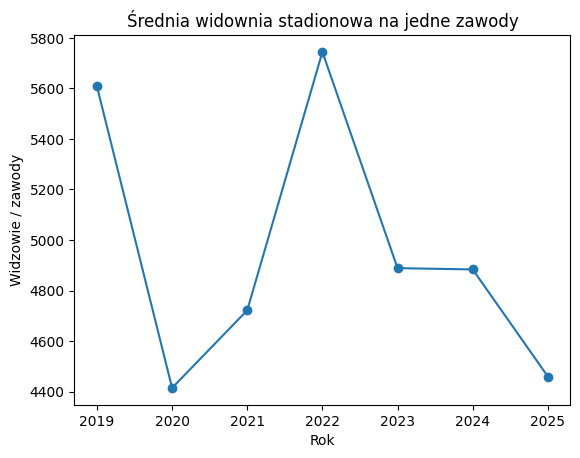

In [8]:
popularity = (
    comp.groupby("year", as_index=False)
        .agg(
            competitions=("competition_id", "count"),
            total_audience=("spectators_stadium", "sum"),
        )
        .sort_values("year")
)

# normalizacja

popularity["audience_per_comp"] = (
    popularity["total_audience"] / popularity["competitions"]
)

popularity
plt.figure()
plt.plot(popularity["year"], popularity["audience_per_comp"], marker="o")
plt.title("Średnia widownia stadionowa na jedne zawody")
plt.xlabel("Rok")
plt.ylabel("Widzowie / zawody")
plt.show()



## 8. Rentowność federacji

Porównujemy przychody i wydatki w czasie:
- **przychody**: dotacje (`funding_sources`) + sponsoring (`sponsorships`),
- **wydatki**: wynagrodzenia pracowników (`employees.salary_amount × 12`).

Wynik prezentujemy jako wykres przychody vs wydatki.

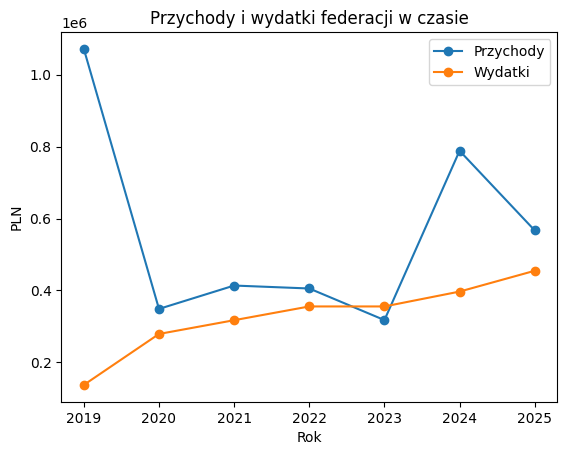

In [9]:
funding_sources = pd.read_sql("SELECT * FROM funding_sources", conn)
sponsorships = pd.read_sql("SELECT * FROM sponsorships", conn)
employees = pd.read_sql("SELECT * FROM employees", conn)

for df in [funding_sources, sponsorships, employees]:
    for c in df.columns:
        if "date" in c:
            df[c] = pd.to_datetime(df[c])

year_min = int(comp["year"].min())
year_max = int(comp["year"].max())

funding_y = (
    funding_sources.assign(year=funding_sources["start_date"].dt.year)
    .query("@year_min <= year <= @year_max")
    .groupby("year", as_index=False)["amount"].sum()
    .rename(columns={"amount": "funding"})
)

sponsorship_y = (
    sponsorships.assign(year=sponsorships["start_date"].dt.year)
    .query("@year_min <= year <= @year_max")
    .groupby("year", as_index=False)["contribution_amount"].sum()
    .rename(columns={"contribution_amount": "sponsorship"})
)


def months_worked_in_year(start_date, end_date, year):
    y_start = pd.Timestamp(year, 1, 1)
    y_end = pd.Timestamp(year, 12, 31)

    s = max(start_date, y_start)
    e = min(end_date if pd.notna(end_date) else y_end, y_end)

    if e < s:
        return 0

    return (e.to_period("M") - s.to_period("M")).n + 1

def payroll_by_year(employees, year_min, year_max):
    rows = []
    for y in range(year_min, year_max + 1):
        total = 0.0
        for _, r in employees.iterrows():
            m = months_worked_in_year(r["start_date"], r["end_date"], y)
            total += float(r["salary_amount"]) * m
        rows.append((y, total))
    return pd.DataFrame(rows, columns=["year", "payroll"])

payroll_y = payroll_by_year(employees, year_min, year_max)
finance = (
    pd.DataFrame({"year": range(year_min, year_max + 1)})
    .merge(funding_y, on="year", how="left")
    .merge(sponsorship_y, on="year", how="left")
    .merge(payroll_y, on="year", how="left")
    .fillna(0.0)
)
finance["income"] = finance["funding"] + finance["sponsorship"]
finance["expenses"] = finance["payroll"]

finance
plt.figure()
plt.plot(finance["year"], finance["income"], marker="o", label="Przychody")
plt.plot(finance["year"], finance["expenses"], marker="o", label="Wydatki")
plt.legend()
plt.title("Przychody i wydatki federacji w czasie")
plt.xlabel("Rok")
plt.ylabel("PLN")
plt.show()


## 9. Atrakcyjność kategorii dla widzów
Porównujemy na wykresie średnią liczbę widzów dla obu kategorii.

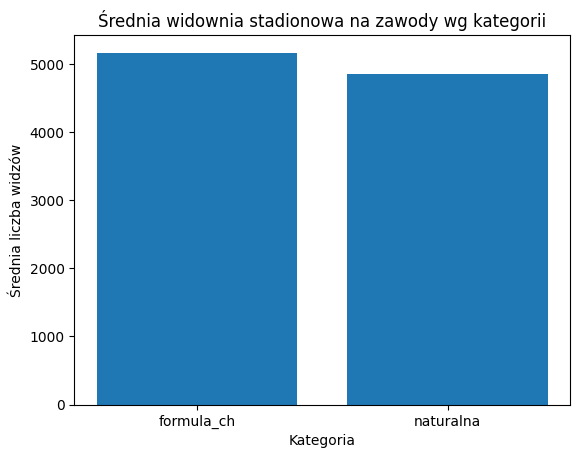

In [15]:
attr_category = (
    comp.groupby("category", as_index=False)
        .agg(
            competitions=("competition_id", "count"),
            total_audience=("spectators_stadium", "sum"),
            avg_audience=("spectators_stadium", "mean")
        )
        .sort_values("avg_audience", ascending=False)
)

attr_category
plt.figure()
plt.bar(attr_category["category"], attr_category["avg_audience"])
plt.title("Średnia widownia stadionowa na zawody wg kategorii")
plt.xlabel("Kategoria")
plt.ylabel("Średnia liczba widzów")
plt.show()


## 10. Czy wiek chomika wpływa na wyniki?
Porównujemy wiek chomika w dniach z osiągniętym przez niego wynikiem (score).

Na podstawie wykresu i testu Pearsona oceniamy czy istnieje jakaś zależność liniowa.

Pearson:
r = -0.097
p-value   = 0.3628


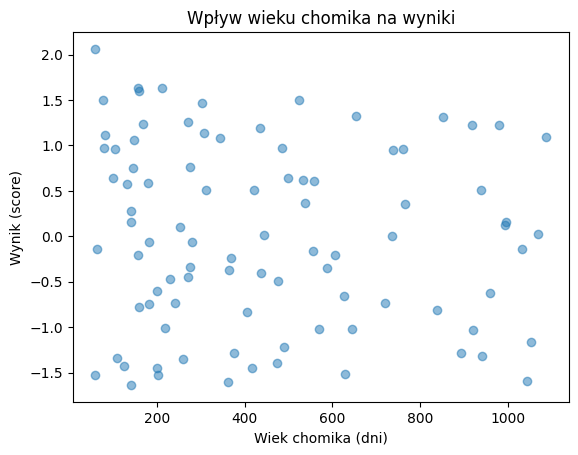

In [10]:
comp_age = comp.copy()
comp_age["age_days"] = (comp_age["competition_date"] - comp_age["birth_date"]).dt.days
comp_age = comp_age[comp_age["age_days"] > 0]
from scipy.stats import pearsonr

# usuwamy ewentualne NaN (bezpieczeństwo)
df = comp_age[["age_days", "score"]].dropna()

r, p = pearsonr(df["age_days"], df["score"])
print("Pearson:")
print(f"r = {r:.3f}")
print(f"p-value   = {p:.4f}")

plt.figure()
plt.scatter(comp_age["age_days"], comp_age["score"], alpha=0.5)
plt.xlabel("Wiek chomika (dni)")
plt.ylabel("Wynik (score)")
plt.title("Wpływ wieku chomika na wyniki")
plt.show()


## 11. Czy płeć chomika wpływa na wyniki?
Tutaj używamy boxplotu aby łatwo sprawdzić wpływ płci na wyniki

In [ ]:
sex_perf = (
    comp.groupby(["sex"], as_index=False)
        .agg(
            events=("competition_id", "count"),
            avg_score=("score", "mean"),
            median_score=("score", "median")
        )
)

sex_perf
male = comp[comp["sex"] == "M"]["score"]
female = comp[comp["sex"] == "F"]["score"]

plt.figure()
plt.boxplot([male, female], tick_labels=["M", "F"])
plt.ylabel("Wynik (score)")
plt.title("Wyniki sportowe chomików a płeć")
plt.show()


## 12. Czy długość kariery (liczba startów) wpływa na wyniki?
Tworzymy wykres, aby sprawdzić czy doświadczenie poprawia wyniki


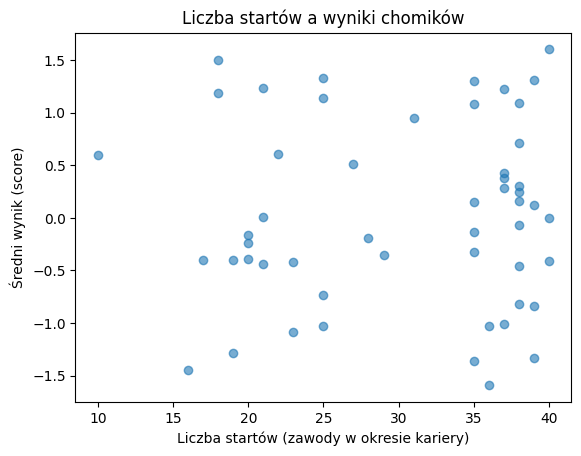

In [11]:
# zakres dat zawodów (globalny)
min_comp_date = comp["competition_date"].min()
max_comp_date = comp["competition_date"].max()

# Wyznaczenie okresu kariery każdego chomika
ham_career = hamsters.copy()
ham_career["career_start"] = ham_career["birth_date"] + pd.Timedelta(days=60)
ham_career["career_end"] = ham_career["retire_date"].fillna(max_comp_date)

ham_career["career_start"] = ham_career["career_start"].clip(lower=min_comp_date)
ham_career["career_end"] = ham_career["career_end"].clip(upper=max_comp_date)

def count_starts(row):
    return comp[
        (comp["competition_date"] >= row["career_start"]) &
        (comp["competition_date"] <= row["career_end"])
    ]["competition_id"].nunique()

ham_career["starts"] = ham_career.apply(count_starts, axis=1)

perf = (
    comp.groupby(["hamster_id", "name_hamster"], as_index=False)
        .agg(
            avg_score=("score", "mean"),
            wins=("competition_id", "count")
        )
)
analysis_p3 = ham_career.merge(
    perf, on="hamster_id", how="left"
).dropna(subset=["avg_score"])

plt.figure()
plt.scatter(
    analysis_p3["starts"],
    analysis_p3["avg_score"],
    alpha=0.6
)
plt.xlabel("Liczba startów (zawody w okresie kariery)")
plt.ylabel("Średni wynik (score)")
plt.title("Liczba startów a wyniki chomików")
plt.show()


## 13. Czy dyscypliny są równie konkurencyjne? 
Tutaj liczymy CV (= std/mean) dla każdej dyscypliny aby ocenić czy są one tak samo konkurencyjne

In [ ]:
competitiveness = (
    comp.groupby(["discipline_id", "name"], as_index=False)
        .agg(
            events=("competition_id", "count"),
            mean_time=("winner_result", "mean"),
            std_time=("winner_result", "std")
        )
)

# współczynnik zmienności
competitiveness["cv"] = competitiveness["std_time"] / competitiveness["mean_time"]

competitiveness = competitiveness.sort_values("cv")

competitiveness
plt.figure()
plt.barh(competitiveness["name"], competitiveness["cv"])
plt.xlabel("Współczynnik zmienności (std / mean)")
plt.title("Konkurencyjność dyscyplin (niższy = bardziej wyrównana)")
plt.show()


## 14. Zamykamy połączenie z bazą danych

In [ ]:

conn.close()
print("Zamknięto połączenie")
